# SPX Options Dataset - Preprocessing and Cleaning

Data is from OptionMetrics from 01/01/2009 to 31/12/2019 on SPX (European only, secid 108105 CBOE), all data is from OptionMetrics unless differently specified.

Characteristics considered:
### Group 1: Basic Options and Underlying Characteristics
1. **Option Price (Midpoint)**
2. **Bid-Ask Spread**
3. **Effective Spread**
4. **Spot Price**
5. **Strike Price**
6. **Forward Price**
7. **Risk-Free Rate**
8. **Dividend Yield on Underlying**
9. **VIX**
10. **Index Return**

### Group 2: Moneyness and Time-related Characteristics
11. **Moneyness**
12. **Time to Maturity**
13. **Volume**
14. **Open Interest**
15. **Volume Weighted Average Price (VWAP)**

### Group 3: Volatility and Skewness/Kurtosis Measures
16. **Historical Volatility**
17. **Implied Volatility (Realised Volatility)**
18. **Model-Free Implied Volatility (Aggregated)**
19. **Model-Free Implied Skewness**
20. **Model-Free Implied Kurtosis**
21. **Realised Skewness**
22. **Realised Kurtosis**

### Group 4: Option Greeks (Sensitivities)
23. **Delta**
24. **Gamma**
25. **Vega**
26. **Theta**
27. **Rho**
28. **Vanna**
29. **Charm**
30. **Vomma**
31. **Zomma**
32. **Color**
33. **DvegaDtime**

### Group 5: Volatility and Skewness/Kurtosis Differentials
34. **RV - IV**
35. **RV - MFvol**
36. **RSkew - MFSkew**
37. **RKurt - MFKurt**



# Imports, Loading, Preliminary Formatting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm
import dask.dataframe as dd
import tqdm
import gc

In [12]:
# Main Dask dataframe
data = dd.read_csv('SPX_2009_2019.csv')

In [13]:
# Dropping unnecessary columns
data = data.drop(columns=['exercise_style', 'secid', 'issuer', 'index_flag', 'ticker', 'forward_price', 'optionid'])

# Date formatting with appropriate formats
data['exdate'] = dd.to_datetime(data['exdate'], format='%d/%m/%Y', dayfirst=True)
data['date'] = dd.to_datetime(data['date'], format='%Y-%m-%d')

# Dividing strike by 1000 (WRDS convention)
data['strike_price'] = data['strike_price'] / 1000

# Time to maturity
data['time_to_maturity_OPT'] = (data['exdate'] - data['date']).dt.days / 365.25

# Renaming columns
data = data.rename(columns={'best_offer': 'best_ask'})
data = data.rename(columns={'exdate': 'expiration'})

# Mapping cp_flag values
data['cp_flag'] = data['cp_flag'].apply(lambda x: 'call' if x == 'C' else 'put', meta=('cp_flag', 'object'))

# Renaming cp_flag to option_type
data = data.rename(columns={'cp_flag': 'option_type'})

In [14]:
# Filtering out expired options and options with no trading volume
data = data[data['expiration'] > data['date']]
data = data[data['volume'] > 0]

In [15]:
# Memory performance management
data = data.persist()

# Merging datasets
- SPX: Underlying spot price - Matching by date (source: OptionMetrics) + Realised Skewness and Kurtosis Calculations
- SPX: Index dividend yield - Averaging per date and matching by date (source: OptionMetrics)
- Zero Coupon Yield Curve: Historical risk-free rate - Matching by closest maturity (source: OptionMetrics)
- SPX: Historical volatility - Matching by closest period (source: OptionMetrics)
- SPX: Forward price - Matching by closest maturity (source: OptionMetrics)
- VIX: Market sentiment indicator - Matching by date (source: CBOE)

In [17]:
# Spot Price - Dask
spot_price = dd.read_csv('SPX_spot_OM_WRDS.csv')
spot_price['date'] = dd.to_datetime(spot_price['date'], format='%d/%m/%Y')

# Columns selection and renaming
spot_price = spot_price[['date', 'close', 'return']].rename(columns={'close': 'spot_price'}) # these are already log returns

# Realised Skewness
def calculate_skewness(log_returns):
    mean_return = log_returns.mean()
    numerator = ((log_returns - mean_return) ** 3).mean()
    denominator = ((log_returns - mean_return) ** 2).mean() ** (3/2)
    return numerator / denominator

# Applying a rolling window to log returns and calculating skewness for each window
spot_price['realised_skewness'] = spot_price['return'].rolling(window=30).apply(calculate_skewness, raw=True)
spot_price = spot_price.persist()
result = spot_price.compute()

# Realised Kurtosis
def calculate_kurtosis(log_returns):
    mean_return = log_returns.mean()
    numerator = ((log_returns - mean_return) ** 4).mean()
    denominator = ((log_returns - mean_return) ** 2).mean() ** 2
    return numerator / denominator

# Applying a rolling window to log returns and calculating kurtosis for each window
spot_price['realised_kurtosis'] = spot_price['return'].rolling(window=30).apply(calculate_kurtosis, raw=True)
spot_price = spot_price.persist()
result = spot_price.compute()

# Merging by date
data = dd.merge(data, spot_price, left_on='date', right_on='date', how='left')

# Memory management
data = data.persist()

# Cleaning
del spot_price

In [18]:
# Dividend Yield - Dask
div_yield = dd.read_csv('SPX_divyield_OM_WRDS.csv')
div_yield['date'] = dd.to_datetime(div_yield['date'], format='%d/%m/%Y')

# Columns selection and renaming
div_yield = div_yield[['date', 'rate']].rename(columns={'rate': 'div_yield'})

# Average dividend yield per date
div_yield_avg = div_yield.groupby('date').agg({'div_yield': 'mean'}).reset_index()

# Merging average dividend yield by date
data = dd.merge(data, div_yield_avg, how='left', on='date')

# Memory management
data = data.persist()

# Cleaning
del div_yield, div_yield_avg 

In [19]:
# Risk-Free Rate - Dask
risk_free = dd.read_csv('SPX_rf_zcyield_OM_WRDS.csv')

# Time to maturity for the risk-free dataset
risk_free['time_to_maturity_ZC'] = risk_free['days'] / 365.25

# Column renaming
risk_free = risk_free.rename(columns={'rate': 'risk_free'})

# Sorting main data and risk_free by respective maturities
risk_free = risk_free.sort_values(by='time_to_maturity_ZC')
data = data.sort_values(by='time_to_maturity_OPT')

# Asof merge to match the closest maturity
data = dd.merge_asof(data, risk_free, left_on='time_to_maturity_OPT', right_on='time_to_maturity_ZC', direction='nearest')

# Memory management
data = data.persist()

# Cleaning
data = data.rename(columns={'date_x': 'date'})
data = data.drop(columns=['date_y', 'days', 'time_to_maturity_ZC'])
del risk_free

In [20]:
# Historical Volatility - Dask
historical_vol = dd.read_csv('SPX_hisvol_OM_WRDS.csv')

# Columns selection and renaming
historical_vol = historical_vol.drop(columns=['index_flag', 'secid', 'ticker'])
historical_vol = historical_vol.rename(columns={'volatility': 'his_volatility'})

# Time to maturity for historical volatility
historical_vol['time_to_maturity_HV'] = historical_vol['days'] / 365.25

# Sorting main data and historical volatility by respective maturities
historical_vol = historical_vol.sort_values(by='time_to_maturity_HV')
data = data.sort_values(by='time_to_maturity_OPT')

# Asof merge to match the closest maturity
data = dd.merge_asof(data, historical_vol, left_on='time_to_maturity_OPT', right_on='time_to_maturity_HV', direction='nearest')

# Memory management
data = data.persist()

# Cleaning
data = data.rename(columns={'date_x': 'date'})
data = data.drop(columns=['date_y', 'days', 'time_to_maturity_HV'])
del historical_vol

In [21]:
# Forward Price - Dask
forward = dd.read_csv('SPX_forward_OM_WRDS.csv')

# Columns selection and renaming
forward = forward.drop(columns=['secid', 'ticker'])
forward = forward.rename(columns={'ForwardPrice': 'forward_price'})

# Datetime format
forward['date'] = dd.to_datetime(forward['date'], format='%d/%m/%Y')
forward['expiration'] = dd.to_datetime(forward['expiration'], format='%d/%m/%Y')

# Time to maturity for forward price
forward['time_to_maturity_FWDd'] = (forward['expiration'] - forward['date']).dt.days
forward['time_to_maturity_FWDy'] = forward['time_to_maturity_FWDd'] / 365.25

# Sorting main data and forward price by respective maturities
forward = forward.sort_values(by='time_to_maturity_FWDy')
data = data.sort_values(by='time_to_maturity_OPT')

# As of merge to match the closest maturity
data = dd.merge_asof(data, forward, left_on='time_to_maturity_OPT', right_on='time_to_maturity_FWDy', direction='nearest')

# Memory management
data = data.persist()

# Cleaning
data = data.rename(columns={'date_x': 'date', 'expiration_x': 'expiration'})
data = data.drop(columns=['date_y', 'time_to_maturity_FWDd', 'time_to_maturity_FWDy', 'expiration_y'])
del forward

In [22]:
# VIX - Dask
vix = dd.read_csv('SPX_vix_CBOE.csv')

# Renaming and formatting
vix = vix.rename(columns={'Date': 'date'})
vix['date'] = dd.to_datetime(vix['date'], format='%d/%m/%Y')

# Merging by date
data = dd.merge(data, vix, how='left', on='date')

# Memory management
data = data.persist()

# Cleaning
del vix

# Characteristics

In [27]:
# 1) Option price (midpoint)
data['option_price'] = (data['best_bid'] + data['best_ask']) / 2

# 2) Bid-ask spread
data['bidask_spread'] = data['best_ask'] - data['best_bid']

# 3) Effective spread
data['effective_spread'] = 2 * data['bidask_spread'] / data['option_price']

# 4) Spot price - Merged
# 5) Strike price - Dataset
# 6) Forward price - Merged
# 7) Risk-free rate - Merged
# 8) Dividend yield - Merged
# 9) VIX - Merged
# 10) Index return - Calculated

# 11) Moneyness
data['moneyness'] = data['spot_price'] / data['strike_price']

# 12) Time to maturity OPT - Calculated
# 13) Volume - Dataset
# 14) Open Interest - Dataset

# 15) Volume weighted average price
data['best_bid_size'] = data['volume'] / 2
data['best_ask_size'] = data['volume'] / 2
data['vwap'] = (data['best_bid'] * data['best_bid_size'] + data['best_ask'] * data['best_ask_size']) / (data['best_bid_size'] + data['best_ask_size'])

# 16) Historical/realised volatility - Merged
# 17) Implied volatility - Dataset

# Memory management
data = data.persist()

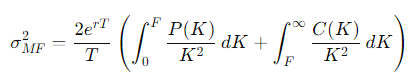
continous (theoretical)

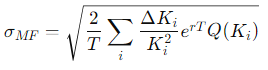
discrete approx

In [28]:
# Converting risk-free rate to decimal
data['risk_free'] = data['risk_free'] / 100

In [29]:
# 18) Model-free implied volatility

T = data['time_to_maturity_OPT']  # Time to maturity
K = data['strike_price']  # Strike price
R = data['risk_free']  # Risk-free rate
Q = data['option_price']  # Combined option prices (call and put)

# Model-free implied volatility - Discrete approximation
def model_free_iv_discrete(T, K, R, Q):
    # Ensuring inputs are numpy arrays and sort by strike price
    K = np.array(K)
    Q = np.array(Q)
    
    sorted_indices = np.argsort(K)
    K = K[sorted_indices]
    Q = Q[sorted_indices]
    
    # Calculating the differences between adjacent strike prices
    delta_K = np.diff(K)
    delta_K = np.append(delta_K, delta_K[-1])  # Last valid difference
    
    # Calculating the summation term in the discrete approximation
    summation_term = np.sum(delta_K / K**2 * Q)
    
    # Calculating model-free implied volatility squared using the discrete approximation
    sigma_mf_squared = (2 / T) * np.exp(R * T) * summation_term
    
    # Returning the square root of the result to get model-free implied volatility
    return np.sqrt(sigma_mf_squared)

# Applying the formula to the data using Dask
data['model_free_iv'] = data.map_partitions(
    lambda df: model_free_iv_discrete(df['time_to_maturity_OPT'], df['strike_price'], df['risk_free'], df['option_price']))

# Memory management
data = data.persist()
result = data.compute()
print(result)

        time_to_maturity_OPT  Unnamed: 0       date expiration option_type  \
0                   0.002738      185030 2018-06-14 2018-06-15        call   
1                   0.002738      350478 2018-08-23 2018-08-24        call   
2                   0.002738      350477 2018-08-23 2018-08-24        call   
3                   0.002738      350476 2018-08-23 2018-08-24        call   
4                   0.002738      350475 2018-08-23 2018-08-24        call   
...                      ...         ...        ...        ...         ...   
122230              2.997947      452402 2010-12-22 2013-12-21         put   
122231              2.997947      467080 2009-12-23 2012-12-22        call   
122232              2.997947      467084 2009-12-23 2012-12-22         put   
122233              2.997947      478164 2011-12-21 2014-12-20         put   
122234              2.997947      452408 2010-12-22 2013-12-21         put   

        strike_price  best_bid  best_ask  volume  open_interest

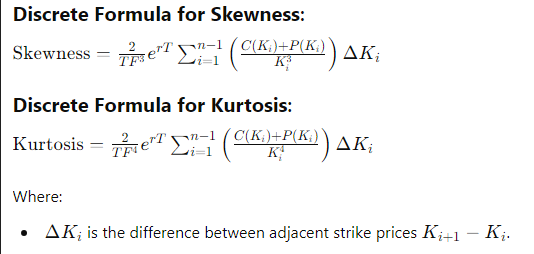

In [30]:
# 19), 20) Model-Free Skewness and Kurtosis


# Discrete approximation for model-free skewness and kurtosis with normalisation
def model_free_skewness_kurtosis_discrete(T, K, R, Q, F):
    # Normalising strike prices by forward price
    K_normalized = np.array(K) / F
    Q_normalized = np.array(Q) / F  # Normalising option prices by forward price
    
    if len(K_normalized) == 0 or len(Q_normalized) == 0:
        return np.nan, np.nan  # Returning NaNs if there's no data to process
    
    sorted_indices = np.argsort(K_normalized)
    K_normalized = K_normalized[sorted_indices]
    Q_normalized = Q_normalized[sorted_indices]
    
    # Calculating the differences between adjacent normalised strike prices
    delta_K = np.diff(K_normalized)
    
    if len(delta_K) > 0:
        delta_K = np.append(delta_K, delta_K[-1])  # Last valid difference
    
    # Discrete integration for skewness
    integrand_skew = Q_normalized / K_normalized**3
    skewness_term = np.sum(delta_K * integrand_skew)
    mf_skewness = (2 / T) * np.exp(R * T) * skewness_term
    
    # Discrete integration for kurtosis
    integrand_kurt = Q_normalized / K_normalized**4
    kurtosis_term = np.sum(delta_K * integrand_kurt)
    mf_kurtosis = (2 / T) * np.exp(R * T) * kurtosis_term
    
    return mf_skewness, mf_kurtosis

# Applying the function to calculate skew and kurt per group
def apply_mf_skew_kurt(df):
    unique_groups = df.groupby(['date', 'expiration'])
    
    skew_list = []
    kurt_list = []
    
    for _, group in unique_groups:
        if len(group) > 1:
            skew, kurt = model_free_skewness_kurtosis_discrete(
                group['time_to_maturity_OPT'].iloc[0],
                group['strike_price'],
                group['risk_free'].iloc[0],
                group['option_price'],
                group['forward_price'].iloc[0]
            )
            skew_list.extend([skew] * len(group))
            kurt_list.extend([kurt] * len(group))
        else:
            skew_list.extend([np.nan] * len(group))
            kurt_list.extend([np.nan] * len(group))
    
    df['model_free_skew'] = skew_list
    df['model_free_kurt'] = kurt_list
    
    return df

# Applying the function across data partitions
data = data.map_partitions(apply_mf_skew_kurt)

# Memory management
data = data.persist()
result = data.compute()
print(result[['model_free_skew', 'model_free_kurt']].head(100))

    model_free_skew  model_free_kurt
0          0.939642         1.464082
1          0.939642         1.464082
2          0.939642         1.464082
3          0.939642         1.464082
4          0.939642         1.464082
..              ...              ...
95        55.622246        61.333982
96        55.622246        61.333982
97        55.622246        61.333982
98        55.622246        61.333982
99        55.622246        61.333982

[100 rows x 2 columns]


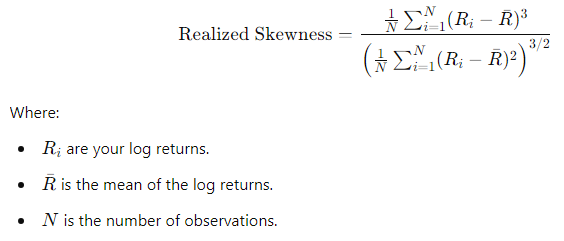

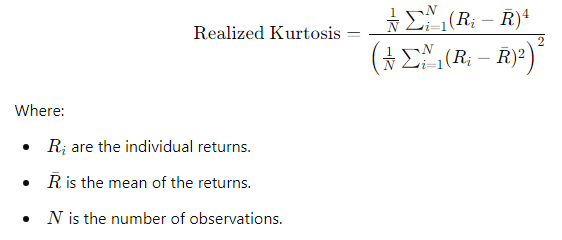

In [31]:
# 21) Realised skewness - Calculated
# 22) Realised kurtosis - Calculated
# 23) Delta - Dataset
# 24) Gamma - Dataset
# 25) Vega - Dataset
# 26) Theta - Dataset

## Greeks Black-Scholes (with yield)

In [32]:
# 27) Rho - Calculated
# 28) Vanna - Calculated
# 29) Charm - Calculated
# 30) Vomma - Calculated
# 31) Zomma - Calculated
# 32) Color - Calculated
# 33) dVega/dTime - Calculated

# Black-Scholes Greeks function
def black_scholes_greeks(S, K, T, r, sigma, q, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = np.where(option_type == 'call',
                     np.exp(-q * T) * norm.cdf(d1),
                     -np.exp(-q * T) * norm.cdf(-d1))
    
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    theta = np.where(option_type == 'call',
                     (-S * norm.pdf(d1) * sigma * np.exp(-q * T) / (2 * np.sqrt(T))) -
                     (r * K * np.exp(-r * T) * norm.cdf(d2)) +
                     (q * S * np.exp(-q * T) * norm.cdf(d1)),
                     (-S * norm.pdf(d1) * sigma * np.exp(-q * T) / (2 * np.sqrt(T))) +
                     (r * K * np.exp(-r * T) * norm.cdf(-d2)) -
                     (q * S * np.exp(-q * T) * norm.cdf(-d1)))
    
    rho = np.where(option_type == 'call',
                   K * T * np.exp(-r * T) * norm.cdf(d2),
                   -K * T * np.exp(-r * T) * norm.cdf(-d2))
    
    # Additional Greeks
    vanna = np.exp(-q * T) * norm.pdf(d1) * (1 - d1 / (sigma * np.sqrt(T)))
    charm = -np.exp(-q * T) * norm.pdf(d1) * (2 * (r - q) * T - d2 * sigma * np.sqrt(T)) / (2 * T * sigma * np.sqrt(T))
    vomma = vega * d1 * d2 / sigma
    zomma = vega * ((d1 * d2 - 1) / sigma)
    color = -np.exp(-q * T) * norm.pdf(d1) / (2 * S * T * sigma * np.sqrt(T)) * (2 * q * T + 1 + d1 / (sigma * np.sqrt(T)) * (2 * (r - q) * T - d2 * sigma * np.sqrt(T)))
    dvega_dtime = vega * (q + (d1 * d2) / (2 * T))
    
    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho,
        'vanna': vanna,
        'charm': charm,
        'vomma': vomma,
        'zomma': zomma,
        'color': color,
        'dvega_dtime': dvega_dtime
    }

# Function to calculate Greeks and add them to main data
def dask_calculate_greeks_no_partitions(data, requested_greeks):
    # Converting the Dask dataframe to a pandas dataframe
    data_pd = data.compute()

    # Calculating greeks using the previously defined function
    greek_values = black_scholes_greeks(
        S=data_pd['spot_price'],
        K=data_pd['strike_price'],
        T=data_pd['time_to_maturity_OPT'],
        r=data_pd['risk_free'],
        sigma=data_pd['impl_volatility'],
        q=data_pd['div_yield'],
        option_type=data_pd['option_type']
    )

    # Assigning only the requested Greeks to the main dataframe
    for greek in requested_greeks:
        if greek in greek_values:
            data_pd[greek] = greek_values[greek]

    # Converting back to a Dask dataframe
    return dd.from_pandas(data_pd, npartitions=1)

# Greeks selection:
requested_greeks = ['rho', 'vanna', 'charm', 'vomma', 'zomma', 'color', 'dvega_dtime']  # List can be adjusted as needed
data = dask_calculate_greeks_no_partitions(data, requested_greeks)


### Comparison metrics

In [33]:
# 34) RV - IV
data['rv_iv'] = data['his_volatility'] - data['impl_volatility']

# 35) RV - MFVol
data['rv_mfvol'] = data['his_volatility'] - data['model_free_iv']

# 36) RSkew - MFSkew
data['rskew_mfskew'] = data['realised_skewness'] - data['model_free_skew']

# 37) RKurt - MFKurt
data['rkurt_mfkurt'] = data['realised_kurtosis'] - data['model_free_kurt']

# Memory management
data = data.persist()
result = data.compute()
print(result[['rv_iv', 'rv_mfvol', 'rskew_mfskew', 'rkurt_mfkurt']].head(100))


       rv_iv    rv_mfvol  rskew_mfskew  rkurt_mfkurt
0        NaN -118.127464     -0.870024      1.224969
0  -0.183662   -0.900034     -2.275974      5.356907
0  -0.026383  -13.065007     -2.130501     -0.918301
0   0.017006   -3.911020     -0.468969      1.623795
0  -0.024995   -0.472580     -1.141822      2.583365
..       ...         ...           ...           ...
2  -0.049563 -118.127464     -1.132342      0.832005
2  -0.046007  -17.596674    -32.849656   -241.615364
2   0.027359  -15.591816    -56.748004   -526.805405
2  -0.499575   -5.865957      0.160186      2.484104
2  -0.042717  -51.440088     -3.639529     -1.154787

[100 rows x 4 columns]


# Payoffs

In [34]:
# Options payoffs
data['call_payoff'] = np.maximum(data['spot_price'] - data['strike_price'], 0)
data['put_payoff'] = np.maximum(data['strike_price'] - data['spot_price'], 0)

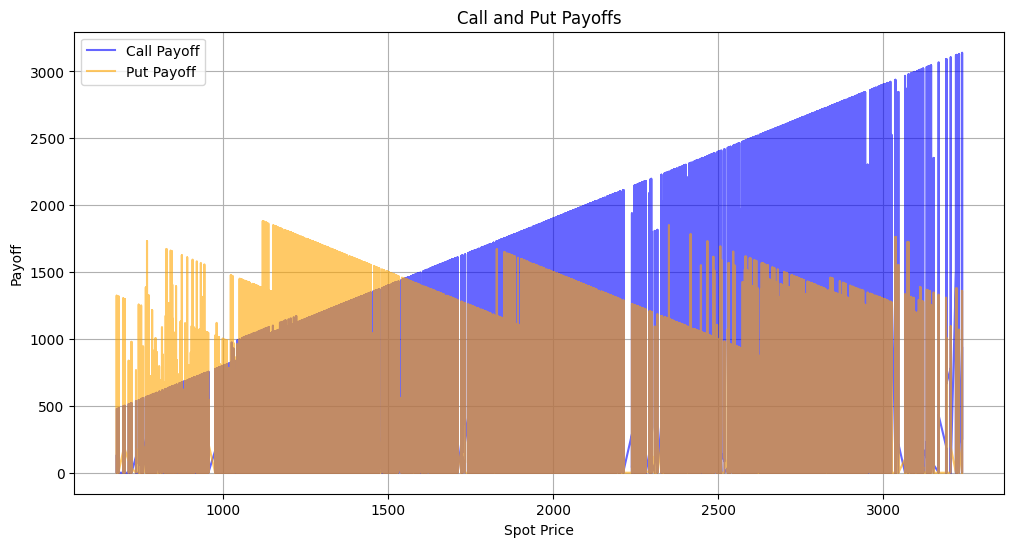

In [36]:

# Computing the Dask dataframe into a pandas one
data_computed = data.compute()
if not isinstance(data_computed, pd.DataFrame):
    raise TypeError("Expected data_computed to be a Pandas DataFrame")

# Sorting by spot price for better visualisation
data_sorted = data_computed.sort_values('spot_price')

# Plot for payoffs
plt.figure(figsize=(12, 6))
plt.plot(data_sorted['spot_price'], data_sorted['call_payoff'], label='Call Payoff', color='blue', alpha=0.6)
plt.plot(data_sorted['spot_price'], data_sorted['put_payoff'], label='Put Payoff', color='orange', alpha=0.6)
plt.xlabel('Spot Price')
plt.ylabel('Payoff')
plt.title('Call and Put Payoffs')
plt.legend()
plt.grid(True)
plt.show()

# Reordering, Saving & Splitting

In [37]:
data = data.sort_values(by='date')

In [38]:
ordered_columns = [
    'date', 'expiration', 'option_type',
    'strike_price', 'spot_price', 'forward_price', 'vix', 'div_yield', 'risk_free', 'time_to_maturity_OPT', 'moneyness',
    'best_bid', 'best_ask', 'option_price', 'bidask_spread', 'effective_spread', 'best_bid_size', 'best_ask_size', 'vwap',
    'volume', 'open_interest',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'vanna', 'charm', 'vomma', 'zomma', 'color', 'dvega_dtime',
    'return', 'his_volatility', 'realised_skewness', 'realised_kurtosis',
    'model_free_iv', 'model_free_skew', 'model_free_kurt',
    'rv_iv', 'rv_mfvol', 'rskew_mfskew', 'rkurt_mfkurt', 'call_payoff', 'put_payoff'
]

# Reordering the columns
data = data[ordered_columns]

# Display check
print(data.head())

             date expiration option_type  strike_price  spot_price  \
76713  2009-01-02 2010-12-18         put        1400.0       931.8   
74839  2009-01-02 2009-12-19        call        1200.0       931.8   
155779 2009-01-02 2009-01-17        call         825.0       931.8   
76933  2009-01-02 2009-03-21        call         800.0       931.8   
59709  2009-01-02 2009-02-21        call        1030.0       931.8   

        forward_price    vix  div_yield  risk_free  time_to_maturity_OPT  ...  \
76713     1271.880759  39.19   3.654123   0.030986              1.957563  ...   
74839     2755.020864  39.19   3.654123   0.004691              0.960986  ...   
155779    1398.473210  39.19   3.654123   0.004760              0.041068  ...   
76933     1396.263033  39.19   3.654123   0.019537              0.213552  ...   
59709     2118.810443  39.19   3.654123   0.013010              0.136893  ...   

        realised_kurtosis  model_free_iv  model_free_skew  model_free_kurt  \
76713         

In [ ]:
# Saving the processed Dask dataframe to a single CSV file
data.to_csv('SPX_Processed_IPCA_Trimmed.csv', single_file=True)

In [ ]:
# Saving puts data
data[data['option_type'] == 'put'].to_csv('SPX_Processed_IPCA_puts_Trimmed.csv', single_file=True)
# Saving calls data
data[data['option_type'] == 'call'].to_csv('SPX_Processed_IPCA_calls_Trimmed.csv', single_file=True)